### 1. Environment Setup

In [ ]:
# 安裝 NeMo Curator CPU 版本及其基本依賴
!pip install -q nemo-curator requests trafilatura ftfy fasttext-wheel python-crfsuite
!pip install -q "dask[dataframe]<2025.0" "distributed<2025.0"
!pip install -q presidio_analyzer presidio_anonymizer opencc-python-reimplemented tiktoken matplotlib huggingface_hub

print("Installed NeMo Curator and other dependencies")

Installed NeMo Curator and other dependencies


NeMo Curator uses Dask for parallelization. Before we start using NeMo Curator, we need to start a Dask cluster. We'll initiate a single-node cpu cluster on colab.

In [2]:
import logging # 引入 logging
from nemo_curator.utils.distributed_utils import get_client, get_num_workers

logging.basicConfig(level=logging.WARNING)
logging.getLogger("dask").setLevel(logging.WARNING)
logging.getLogger("distributed").setLevel(logging.WARNING)


def initialize_client(device):
    if device == "cpu":
        try:
            # client.cluster.close()
            # client.shutdown()
            client = get_client(
                cluster_type = "cpu",
                n_workers = 1,
                threads_per_worker = 4,
                processes = False,
                memory_limit = "0"
            )
            print(f"CPU cluster initialized with {get_num_workers(client)} workers")

        except Exception as e:
            print(f"Failed on initializing CPU cluster: {e}")
            client = None
        return client
    elif device == 'cuda':
        # 這部分需要你的 Colab 環境有 GPU 且已成功安裝 RAPIDS/cuDF
        client = None
        try:
            import dask_cudf
            import cudf
            client = get_client(cluster_type = "gpu")
            print(f"GPU cluster initialized with {get_num_workers(client)} workers")
            gpu_available = True
        except ImportError:
            print("\nCuDF not found")
        except Exception as e:
            print(f"Failed on initializing GPU cluster: {e}")
            client = None
        return client
    raise NotImplementedError

In [1]:
import os
import time
import io
import unicodedata
import pathlib
import subprocess
import sys
import re
import fasttext
import pandas as pd
import numpy as np
import warcio.archiveiterator
import pycld2 as cld2
import justext
import tiktoken
import opencc
from ftfy import TextFixerConfig

import nemo_curator as nc
from nemo_curator.utils.file_utils import (
    get_all_files_paths_under,
    separate_by_metadata,
)
from nemo_curator.download import (
    ResiliparseExtractor,
    CommonCrawlWARCDownloaderExtractOnly,
    CommonCrawlWARCIterator,
    CommonCrawlWARCExtractor,
    download_and_extract,
)
from nemo_curator.datasets import DocumentDataset
from nemo_curator.modifiers import UnicodeReformatter
from nemo_curator.filters import (
    FastTextLangId,
    DocumentFilter,
)
from nemo_curator import (
    Sequential,
    Score,
    Modify,
    ScoreFilter,
    Filter
)
from huggingface_hub import hf_hub_download
from default import zh_stopwords

/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 3. Data Acquisition & Loading
In this section, we will discuss how to handle raw Common Crawl data files (warc.gz) that you have already obtained, extract the relevant text content, and load it into a DocumentDataset using NeMo Curator.

- About Common Crawl Data  
Common Crawl is a non-profit organization that crawls the web and provides open datasets of web crawl data. These datasets are massive, containing petabytes of data in formats like WARC (Web ARChive), WAT (Web Archive Transformation), and WET (Web Extracted Text). Data derived from Common Crawl is a common source for training large language models.

Raw Common Crawl data (WARC/WAT files) is complex and requires specialized tools for parsing and extracting content. For the purpose of this tutorial in a Colab environment, we will work with a small sample of warc.gz files.

#### 3.1 Download common crawl samples

In [ ]:
raw_warc_dir = "./cc_sample"
raw_warc_files = get_all_files_paths_under(raw_warc_dir)
if raw_warc_files:
    print(f"Found {len(raw_warc_files)} .warc.gz files:")
    for f in raw_warc_files:
        print(f"  - {f}")

Found 2 .warc.gz files:
  - ./cc_sample/crawl-data-CC-MAIN-2025-18-segments-1744889135610.12-warc-CC-MAIN-20250417135010-20250417165010-00000.warc.gz
  - ./cc_sample/crawl-data-CC-MAIN-2025-18-segments-1744889135610.12-warc-CC-MAIN-20250417135010-20250417165010-00001.warc.gz


#### 3.2 Extracting plain text from WARC

In [ ]:
# Reading from WARC
file_path = raw_warc_files[0]
docs_to_extract = []
with open(file_path, 'rb') as stream:
    for record in warcio.archiveiterator.ArchiveIterator(stream):
        if record.rec_type == 'response':
            if record.http_headers.get_header('Content-Type') == 'text/html':
                http_response = record.content_stream().read()
            try:
                html_content = http_response.decode('utf-8')
                doc_id = os.path.split(file_path)[-1] + record.rec_headers.get('WARC-Record-ID')
                doc_to_extract = {
                    "id": doc_id,
                    "html_content": html_content,
                }
                docs_to_extract.append(doc_to_extract)
                if len(docs_to_extract) >= 5: break
            except UnicodeDecodeError:
                print(f"Warning: Could not decode content in {file_path} for record {record.rec_headers.get('WARC-Record-ID')}")
                continue


print(html_content)

<urn:uuid:3305c92c-cb06-4f62-a920-b07aab5c6e4a>
<urn:uuid:1b74ea4a-6016-47ea-ae08-724286576095>
<urn:uuid:aa80971d-38af-491a-a602-7caa7653db4b>
<urn:uuid:b3e51608-57e6-4b0b-a9f9-b910ed4fda69>
<urn:uuid:3abc0dd7-b099-442f-8254-17e6a6151d92>
<!DOCTYPE html>
<html lang="zh-CN">
<head>
<meta charset="UTF-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1"/>
<meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0, user-scalable=0">
<meta name="applicable-device" content="pc,wap">
<meta name="MobileOptimized" content="width"/>
<meta name="HandheldFriendly" content="true"/>
<title>石材切割污水_陜西華星佳洋裝備制造有限公司</title>
<meta name="keywords" content="壓濾機(jī),隔膜壓濾機(jī),板框壓濾機(jī)" />
<meta name="description" content="石材切割過程中會(huì)產(chǎn)生大量的石粉顆粒，這些顆粒會(huì)隨著水流進(jìn)入廢水，導(dǎo)致廢水中懸浮物含量極高，可高達(dá)數(shù)千毫克每升甚至更高。廢水通常呈現(xiàn)出明顯的渾濁狀態(tài)，靜置一段時(shí)間后，會(huì)有大量的沉淀物在底部堆積。" />
<link rel="stylesheet" href="http://0752tz.com/static/default/web/css/animate.min.

In [ ]:
cc = opencc.OpenCC('s2t')
extractor = ResiliparseExtractor()

def lang_detect(html_text: str) -> str:
    details = cld2.detect(html_text.encode("utf-8", errors="ignore"))[2]
    return details[0][0].upper()

for d, doc_to_extract in enumerate(docs_to_extract):
    html = doc_to_extract["html_content"]
    # removing control characters
    html = "".join(ch for ch in html if unicodedata.category(ch)[0] != "C")
    lang = lang_detect(html)
    print(f'----- Extracting Doc {d} -----')
    print(f"Main Language: {lang}")
    if lang == "CHINESE":
        stop_words = zh_stopwords
    elif lang == "CHINESET":
        stop_words = [cc.convert(w) for w in zh_stopwords]
        lang = "CHINESE"
    else:
        stop_words = justext.get_stoplist(lang)
    plain_text = extractor.extract_text(
        html,
        stop_words=stop_words,
        language=lang,
    )
    print(f"Extracted Text: \n{plain_text!r}")



----- Extracting Doc 0 -----
Main Language: CHINESET
Extracted Text: 
['日韩精品一区二区中文在线观-精品久久久久久中文人妻-中文字幕 日韩精品在线-久久—日本道色综合久久', '高精度電子皮帶秤', '高精度電子皮帶秤又可分為14型、17型皮帶秤，是企業(yè)產(chǎn)量監測的好幫手，它采用全懸浮式稱(chēng)重橋架、或整體杠桿式結構，無(wú)需支點(diǎn)可移動(dòng)，獨特的矩形杠桿，剛性好、無(wú)變形、零點(diǎn)穩定性更好，該類(lèi)型電子皮帶秤的長(cháng)期穩定性和稱(chēng)重的高精度性無(wú)法比擬，產(chǎn)品主要應用于現場(chǎng)工藝要求高或需要進(jìn)行貿易結算的行業(yè)現場(chǎng)。', '精度 0.25%', '皮帶機傾角 ≤6°、 ≤17°', '稱(chēng)重傳感器 2、4', '速度傳感器 1', '稱(chēng)重橋架 全懸浮、雙杠桿', '計量托輥 4', '高精度電子皮帶秤產(chǎn)品特點(diǎn)', 'PRODUCT FEATURES', '高精度皮帶秤稱(chēng)重橋架', '高精度電子皮帶秤采用全懸浮式秤架結構或整體杠桿式結構，該種形式的橋架、可選A、B兩種形式，秤架不會(huì )產(chǎn)生粘料，無(wú)耳軸支點(diǎn)可移動(dòng)件，采用單元組件結構、力的傳遞環(huán)節少、安裝簡(jiǎn)單便捷，易安裝、免維護、精度高、運行穩、', '不銹鋼觸摸屏稱(chēng)重儀表', '不銹鋼觸摸屏稱(chēng)重儀表，采用7寸液晶屏顯示、32位高性能處理器，全彩色界面、觸摸操作、實(shí)現中文人機對話(huà)、直觀(guān)顯示各種相關(guān)信息，信號全隔離、抗干擾能力強，全新零點(diǎn)自動(dòng)追蹤技術(shù)，一鍵操作，操作記錄存儲，方便回溯問(wèn)題，功能強大，具有在線(xiàn)分析、重量補償等多種智能功能。', '數字式稱(chēng)重傳感器', '自主研發(fā)的數字式稱(chēng)重傳感器采用現場(chǎng)總線(xiàn)技術(shù)、數字通訊速度更快、傳輸距離更遠，數據更可靠，以32位處

Extractor only uses imple language identification and unicode reformatting, we will introduce detailed clean up in Section 4

In [ ]:
out_dir = "./cc_sample_extracted"
os.makedirs(out_dir, exist_ok=True)
dataset = download_and_extract(
    urls=raw_warc_files,
    output_paths=[f"{out_dir}/{i}.jsonl" for i in range(len(raw_warc_files))],
    downloader=CommonCrawlWARCDownloaderExtractOnly(),
    iterator=CommonCrawlWARCIterator(),
    extractor=CommonCrawlWARCExtractor(algorithm=ResiliparseExtractor(required_stopword_density=0.32)),
    # stopword density is uncountable in non-space-separated languages, unless the paragraph is pre-tokenized
    output_format={"url": str, "text": str, "file_name": str},
    keep_raw_download=True,                        
)
dataset.df.head()


,language,text,url,warc_id,source_id,file_name
0,JAPANESE,請更新你的瀏覽器\n\n系統不再支援你使用的瀏覽器。如要獲得最優質體驗並使用我們的最新功能，...,http://0204.ut-kk69.com/V4/?AID=224257&FID=267...,1b74ea4a-6016-47ea-ae08-724286576095,crawl-data-CC-MAIN-2025-18-segments-1744889135...,0.jsonl
1,CHINESE,• 登录\n\n社交账号登录\n\n泉州hpv检查费用多少 > 性功能障碍 > 早泄\n...,http://0595nk120.com/180/dy/1112.html,aa80971d-38af-491a-a602-7caa7653db4b,crawl-data-CC-MAIN-2025-18-segments-1744889135...,0.jsonl
2,CHINESE,"国产av成人,911xxx婷婷 丁香,久久久簧片,91精品无码尤物\n\n歡迎光臨板框壓濾機...",http://0752tz.com/shicaiwushui/,b3e51608-57e6-4b0b-a9f9-b910ed4fda69,crawl-data-CC-MAIN-2025-18-segments-1744889135...,0.jsonl
3,JAPANESE,2020年9月28日月曜日\n\n080-6521-9178\n\n上4桁選択 > 080-...,http://090-080-070.blogspot.com/2020/09/080-65...,3abc0dd7-b099-442f-8254-17e6a6151d92,crawl-data-CC-MAIN-2025-18-segments-1744889135...,0.jsonl
4,RUSSIAN,Мифы о похудении\n\nСегодня проблема лишнего в...,http://100dieta.ru/mify-o-poxudenii,7e6de856-949c-4970-a79d-be5b35087832,crawl-data-CC-MAIN-2025-18-segments-1744889135...,0.jsonl


#### 3.3 DocumentDataset

In NeMo Curator, the `DocumentDataset` is a fundamental data structure designed to hold and manage large-scale text datasets. It serves as the primary container for your documents throughout the curation pipeline.

**Relationship with Dask DataFrame:**
At its core, a `DocumentDataset` is essentially a wrapper around a [Dask DataFrame](https://docs.dask.org/en/stable/dataframe.html). Dask DataFrames are designed to parallelize Pandas-like operations on datasets that may be larger than memory. 
In the previous step (3.2), when we used `download_and_extract`, the resulting `dataset` object contains a Dask DataFrame (`dataset.df`) with columns like `url`, `text`, `file_name`, `warc_id`, and `source_id`. If we were to add language identification, a `language` column would also be present.

**Inspecting and Operating on `DocumentDataset`:**

You interact with the data in a `DocumentDataset` primarily through its `.df` attribute. Since it's a Dask DataFrame, you can use familiar Pandas-like syntax

In [ ]:
dataset.to_json("cc_sample_extracted", write_to_filename=True)

Writing to disk complete for 2 partition(s)


In [ ]:
dataset = DocumentDataset.read_json(get_all_files_paths_under('./cc_sample_extracted'), add_filename=True)
dataset.df.head()

AttributeError: 'NoneType' object has no attribute 'run'

In [ ]:
print(f"\nTotal number of documents in the dataset: {len(dataset)}")

# how the data is distributed for parallel processing.
num_partitions = dataset.df.npartitions
print(f"The Dask DataFrame is divided into {num_partitions} partition(s).")

# calculate number of unique langauges

value_counts_ddf = dataset.df['language'].value_counts()
value_counts_result = value_counts_ddf.compute().sort_values()
print(value_counts_result)



Total number of documents in the dataset: 45582
The Dask DataFrame is divided into 2 partition(s).
language
CEBUANO         1
JAVANESE        1
BRETON          2
TAGALOG         2
MALTESE         2
            ...  
SPANISH      2215
GERMAN       2419
JAPANESE     2649
RUSSIAN      2916
ENGLISH     19983
Name: count, Length: 73, dtype: int64


In [ ]:
# Blending dataset, useful for data mixing
dataset1 = DocumentDataset.read_json('./cc_sample_extracted/0.jsonl', add_filename=True)
dataset2 = DocumentDataset.read_json('./cc_sample_extracted/1.jsonl', add_filename=True)
target_samples = 1000
weights = [5, 1]
# persist(): actually compute large-scale results, so future computations do need to repeat previous steps
blended_dataset = nc.blend_datasets(target_samples, [dataset1, dataset2], weights).persist()
shuffled_dataset = nc.Shuffle(seed=7)(blended_dataset).persist()
shuffled_dataset.df.head()

Reading 1 files with blocksize='1gb' / files_per_partition=None
Reading 1 files with blocksize='1gb' / files_per_partition=None


,file_name,language,source_id,text,url,warc_id
0,file_0000000000.jsonl,ENGLISH,crawl-data-CC-MAIN-2025-18-segments-1744889135...,New cooking dailies are now available in Darna...,http://kharinsquest.com/tag/lets-do-lunch/,fbe3f183-2fc3-4649-806a-3d140dc2438f
1,file_0000000000.jsonl,ENGLISH,crawl-data-CC-MAIN-2025-18-segments-1744889135...,a,http://athletics.hn.psu.edu/sports/msoc/2014-1...,5ac32426-d79e-4261-a5ae-81548fa9f147
2,file_0000000000.jsonl,CHINESE,crawl-data-CC-MAIN-2025-18-segments-1744889135...,亚洲精品国产日韩无码AV永久免费网_国产成人亚洲影院在线播放_国产草莓视频无码a在线观看_久...,http://ledomainedecocodo.com/wiki/623.html,afa9ac8f-f1af-42b1-805b-11ecfc406a22
3,file_0000000000.jsonl,LITHUANIAN,crawl-data-CC-MAIN-2025-18-segments-1744889135...,2024 m. birželio 14 d. Mokinių priėmimo komisi...,http://ausros.lt/lt/naujienos/svarbu/2024/06/k...,26458185-120f-43f7-a742-360eb747e1b7
4,file_0000000000.jsonl,CHINESE,crawl-data-CC-MAIN-2025-18-segments-1744889135...,"三年片在线观看免费大全电影,国产乱子伦视频大全,亚洲美腿丝袜无码专区,一二三四在线播放免费观...",http://fairchild-jeans.com/news/company,d737e27d-ae6d-4018-aa09-94ddf5157ba2


### 4. Document Normalization & Basic Cleaning
Large-scale web text is noisy: inconsistent encodings, multiple human languages in the same page, leftover HTML, etc.  
Before we push data through heavier quality filters, we’ll run a *light* but *high-precision* “clean & gate” stage:

1. **Unicode Reformatter** – uses *ftfy* under the hood to repair mojibake, stray control codes, surrogate pairs…  
2. **FastText Language ID** – detects the *main* language of each cleaned document and assigns a probability score.  

**Why run Language ID *after* Unicode fixing?**  
Garbled bytes can lower FastText accuracy, need to do normalising first ensures the LID model sees clean UTF-8.



#### 4.1  Unicode repair → Language identification

Ref: [UnicodeReformatter](https://github.com/NVIDIA/NeMo-Curator/blob/c006da8b106bda3da200aa623ebf5033487a08a4/nemo_curator/modifiers/unicode_reformatter.py#L23) and [ftfy config](https://ftfy.readthedocs.io/en/latest/config.html)


In [ ]:
FASTTEXT_MODEL = "./lid.176.bin"
MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"

if not os.path.exists(FASTTEXT_MODEL):
    print(f"Downloading {MODEL_URL} → {FASTTEXT_MODEL} (~126 MB)")
    subprocess.run(["wget", "-q", "-c", MODEL_URL, "-O", str(FASTTEXT_MODEL)], check=True)
else:
    print("lid.176.bin already present – skipping download")

lid.176.bin already present – skipping download


In [ ]:
dataset = DocumentDataset.read_json(get_all_files_paths_under('./cc_sample_extracted'), add_filename=True)
unicode_fix = UnicodeReformatter(
    config = TextFixerConfig(
        remove_control_chars = True,
        explain = True,
        fix_line_breaks = True
    ),
    explain = True
)
modifier = Modify(unicode_fix, text_field='text')
# a filter has basic two functions: score_document and keep_document
lang_id = FastTextLangId(
    model_path = FASTTEXT_MODEL,
    min_langid_score = 0.0 # we will keep every document temporarily
)
scorer = Score(lang_id, text_field='text', score_field='language', score_type='object')
dataset = Sequential([modifier, scorer])(dataset).persist()
dataset.df.head(3)


Reading 2 files with blocksize='1gb' / files_per_partition=None


,file_name,language,source_id,text,url,warc_id
0,0.jsonl,"[0.999329686164856, ZH]",crawl-data-CC-MAIN-2025-18-segments-1744889135...,"請更新你的瀏覽器\n\n系統不再支援你使用的瀏覽器。如要獲得最優質體驗並使用我們的最新功能,...",http://0204.ut-kk69.com/V4/?AID=224257&FID=267...,1b74ea4a-6016-47ea-ae08-724286576095
1,0.jsonl,"[0.9642771482467651, ZH]",crawl-data-CC-MAIN-2025-18-segments-1744889135...,• 登录\n\n社交账号登录\n\n泉州hpv检查费用多少 > 性功能障碍 > 早泄\n...,http://0595nk120.com/180/dy/1112.html,aa80971d-38af-491a-a602-7caa7653db4b
2,0.jsonl,"[0.8113250732421875, ZH]",crawl-data-CC-MAIN-2025-18-segments-1744889135...,"国产av成人,911xxx婷婷 丁香,久久久簧片,91精品无码尤物\n\n歡迎光臨板框壓濾機...",http://0752tz.com/shicaiwushui/,b3e51608-57e6-4b0b-a9f9-b910ed4fda69


In [ ]:
# Language distribution statistics
import dask.dataframe as dd
dataset.df["language_code"] = dataset.df["language"].map( lambda x: x[1], meta=("language_code", "str")) # tell Dask the return type
dataset.df["language_prob"] = dataset.df["language"].map( lambda x: x[0], meta=("language_prob", "float"))
dataset.df = dataset.df.drop(columns=['language'])
lang_counts = dataset.df["language_code"].value_counts().compute().sort_values(ascending=False)
lang_counts.head(10)

language_code
EN    20131
RU     2925
JA     2508
DE     2412
ES     2237
FR     2047
ZH     2003
IT     1199
PT     1174
PL      972
Name: count, dtype: int64

`.compute` v.s. `.persist()`  

`ddf.compute()`:
- return pandas.Series (or DataFrame if you slice many columns)	
- stored on driver RAM only – every partition is materialised and concatenated before the call return
- usecase: when the column is small enough to fit in memory and you want to use the full pandas API or hand the values to another library  

`ddf.persist()`:
- return dask.dataframe.Series or dask.dataframe.DataFrame (same lazy type, but its partitions are now cached in the workers)	
- stays distributed; each worker keeps its own pandas chunk
- usecase: when you will reuse the column many times (or chain more Dask ops) and don’t want to recompute it every time

In [ ]:
target_langs = ["EN", "ZH"]
separate_by_metadata(
    dataset.df[dataset.df['language_code'].isin(target_langs)],
    "./cc_sample_lang_sep",
    metadata_field='language_code',
).compute()

{'EN': 20131, 'ZH': 2003}

### 5.  Low-Quality Text Filtering
We now possess **Unicode-clean, language-tagged** documents.  
Before they enter model pre-training we must prune obvious “junk”: ultra-short
snippets, copy–pasted navigation bars, high-perplexity gibberish, etc.

Common Filtering Approaches

|   | What it removes | Runs on |
|---|-----------------|---------|
| Heuristics *(5.1)* | Length, character set, duplicate lines… | CPU |
| Boiler-plate (already at extract time)  | Ads, menus, script tags, Nav Bar | CPU |
| Quality Classifier *(5.2)* | Text classified as low-quality | GPU/CPU |
| Perplexity *(5.3)* | Text the LM finds improbable | GPU/CPU |

In [13]:
dataset = DocumentDataset.read_json(get_all_files_paths_under('./cc_sample_lang_sep/EN'), add_filename=True)
print(f'Number of documents: {len(dataset)}')

Reading 2 files with blocksize='1gb' / files_per_partition=None
Number of documents: 20131


#### 5.1 Filter Intro & Heuristic Filters

In [12]:
import tiktoken
from nemo_curator.filters import DocumentFilter
from nemo_curator import ScoreFilter
# A filter consists of score and keep document function
class TokenCountFilter(DocumentFilter):
  def __init__(self, min_tokens=50, max_tokens=10000, lang='EN'):
    self._min_tokens = min_tokens
    self._max_tokens = max_tokens
    self._tokenizer = tiktoken.encoding_for_model("gpt-4o")
    self._name = 'token_count'

  def score_document(self, text: str):
    return len(self._tokenizer.encode(text))

  def keep_document(self, score: int):
    return self._min_tokens <= score <= self._max_tokens

# Create a filter for the whole dataset
filter = ScoreFilter(TokenCountFilter(), text_field='text', score_field='token_count')
# you can also use Score to only score the documents
filtered_dataset = filter(dataset)
print(f'Number of documents: {len(filtered_dataset)}')


NameError: name 'dataset' is not defined

In [5]:
# You can also chain multiple filters
from nemo_curator.filters import RepeatingTopNGramsFilter, WordCountFilter

filters = Sequential([
    ScoreFilter(TokenCountFilter(), text_field='text', score_field='token_count'),
    ScoreFilter(RepeatingTopNGramsFilter(n=2, max_repeating_ngram_ratio=0.2), text_field='text'),
    ScoreFilter(WordCountFilter(min_words=50), text_field='text'),
])
filtered_dataset = filters(dataset)
print(f'Number of documents: {len(filtered_dataset)}')

Number of documents: 12707


In [6]:
# You can also load filters from a config file
from nemo_curator.utils.config_utils import build_filter_pipeline
filters = build_filter_pipeline('./heuristic_filter.yaml')
filtered_dataset = filters(dataset)
print(f'Number of documents: {len(filtered_dataset)}')

Number of documents: 10116


#### 5.2 Quality Classifiers
QC can be trained with low/high-quality data, and output multi-class or floating-point values.

> I'll recommend [training a fasttext model](https://fasttext.cc/docs/en/supervised-tutorial.html) than training a transformer-based models, such as RoBERTa, due to efficiency.

**BE AWARE OF AVAILABLE LANGUAGE**


In [17]:
import matplotlib.pyplot as plt
# a helper function to help us plot score distribution
def plot_score_dist(title, scores: pd.Series):

    # Plot the distribution as a histogram with a Gaussian curve overlay
    plt.figure(figsize=(10, 6))
    scores.hist(bins=50, density=True, alpha=0.6, color="skyblue")

    # Overlay a Gaussian curve
    mu = scores.mean()
    sigma = scores.std()
    x = np.linspace(scores.min(), scores.max(), 100)
    plt.plot(
        x,
        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2),
        color="red",
        linewidth=2,
        label="Gaussian Curve",
    )

    plt.title(title)
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

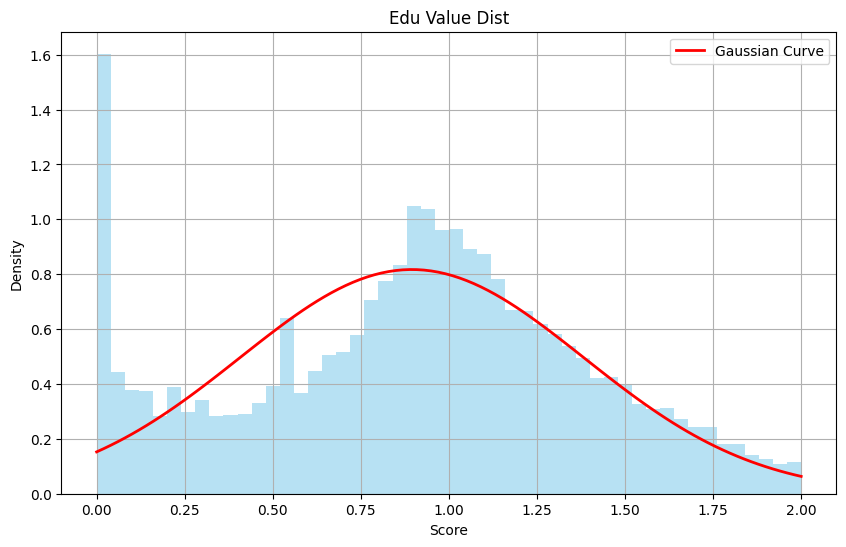

In [ ]:
from nemo_curator.utils.decorators import batched
from nemo_curator.utils.distributed_utils import NoWorkerError, load_object_on_worker
MODEL_PATH = hf_hub_download(
    repo_id="kenhktsui/llm-data-textbook-quality-fasttext-classifier-v2",
    filename="model_quantized.bin",
    local_dir='./fasttext_model'
)

class FastTextQualityFilter(DocumentFilter):
    def __init__(self, model_path: str | None = None, seed: int = 42):
        if model_path is None:
            msg = "Must provide a valid path to a FastText model to compute document scores with this filter"
            raise ValueError(msg)
        self._model_path = model_path
        self._name = "fasttext_quality_filter"

    @batched
    def score_document(self, df: pd.Series) -> pd.Series:
        model_attr = f"{self._name}_{self._model_path}"
        try:
            model = load_object_on_worker(model_attr, self._load_model, {})
        except NoWorkerError:
            return pd.Series(np.ones(len(df)), dtype=float)

        def _score_document(text: str) -> float:
            score_dict = {
                '__label__': 0, 
                '__label__Low': 0, 
                '__label__Mid': 1,
                '__label__High': 2
            }
            pred = model.predict([re.sub("\n+", " ", text)], k=-1)
            for l, s in zip(*pred):
                score = 0
                for _l, _s in zip(l, s):
                    score += score_dict[_l] * _s
                return float(score)
        # remember to include the index in the returned df e.g. pd.Series(scores, index=documents.index)
        return df.apply(_score_document) 

    @batched
    def keep_document(self, df: pd.Series) -> pd.Series:
        return df >= 1  # noqa: NPY002

    def _load_model(self) -> fasttext.FastText:
        return fasttext.load_model(self._model_path)

scorer = Score(FastTextQualityFilter(model_path='./fasttext_model/model_quantized.bin'), text_field='text', score_field='educational_value')
scored_dataset = scorer(dataset)
plot_score_dist("Edu Value Dist", scored_dataset.df['educational_value'].compute())

Number of documents: 8772


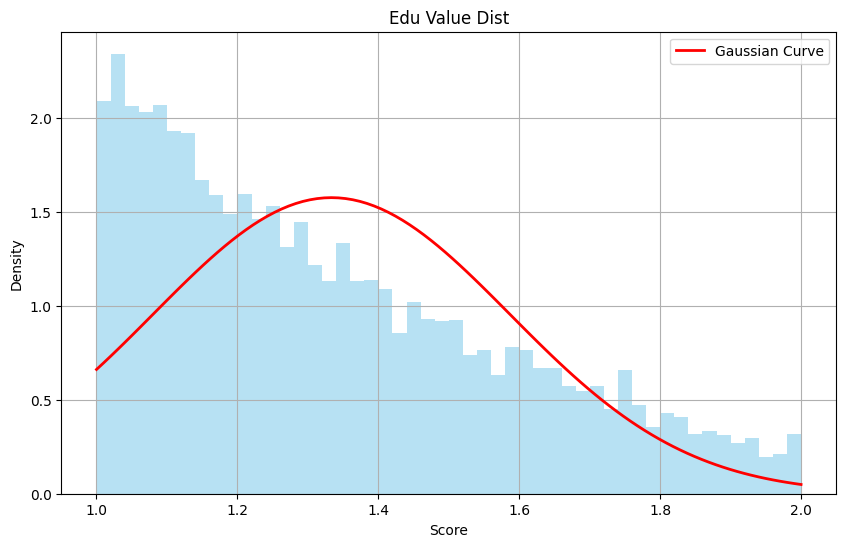

In [31]:
# You can choose ScoreFilter or Score then Filter (better for knowing dist first)
filter = Filter(FastTextQualityFilter(model_path='./fasttext_model/model_quantized.bin').keep_document, filter_field="educational_value")
filtered_dataset = filter(scored_dataset)
print(f'Number of documents: {len(filtered_dataset)}')
plot_score_dist("Edu Value Dist", filtered_dataset.df['educational_value'].compute())

In [ ]:
# You can also use a nvidia-provided transformer-based classifier (recommended for GPU)
# see https://huggingface.co/nvidia/quality-classifier-deberta
# from nemo_curator.classifiers import QualityClassifier

# scorer = QualityClassifier(
#     filter_by = ["High", "Medium"], 
#     device_type = 'cpu', 
#     batch_size = 64,
#     pred_column = 'nv_quality'
# )
# scored_dataset = scorer(dataset=dataset)

2025-05-21 12:07:16,805 - distributed.protocol.pickle - ERROR - Failed to serialize <class 'nemo_curator.utils.import_utils.MISSINGget_device_total_memory'>.
Traceback (most recent call last):
  File "/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 60, in dumps
    result = pickle.dumps(x, **dump_kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.PicklingError: Can't pickle <class 'nemo_curator.utils.import_utils.MISSINGget_device_total_memory'>: attribute lookup MISSINGget_device_total_memory on nemo_curator.utils.import_utils failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/distributed/protocol/pickle.py", line 65, in dumps
    pickler.dump(x)
_pickle.PicklingError: Can't pickle <class 'nemo_curator.utils.import_utils.MISSINGget_device_total_memory'>: attribute lookup MISSI

UnavailableError: dask_cuda.utils.get_device_total_memory is not enabled in non GPU-enabled installations or environments. Install GPU packages via `pip install --extra-index-url https://pypi.nvidia.com nemo-curator[cuda12x]`
or use `pip install --extra-index-url https://pypi.nvidia.com ".[cuda12x]"` if installing from source

#### 5.3 Perplexity filtering
Perplexity essentially tells us how probable the LM thinks the text is.   
We first download English checkpoints from huggingface

In [ ]:
!pip install sentencepiece https://github.com/kpu/kenlm/archive/master.zip
os.makedirs("./kenlm", exist_ok=True)
# Download KenLM pre-trained models
hf_hub_download(
    repo_id="edugp/kenlm",
    filename="./wikipedia/en.arpa.bin",
    local_dir='./kenlm'
)

hf_hub_download(
    repo_id="edugp/kenlm",
    filename="./wikipedia/en.sp.model",
    local_dir='./kenlm'
)

hf_hub_download(
    repo_id="edugp/kenlm",
    filename="./wikipedia/en.sp.vocab",
    local_dir='./kenlm'
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.6/553.6 kB 8.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


'kenlm/wikipedia/en.sp.vocab'

In [10]:
from kenlm_utility import KenlmModel
class PerplexityFilter(DocumentFilter):
    def __init__(self, threshold: float, models_dir: str) -> None:
        self._kenlm_model = KenlmModel(model_path=models_dir, language="en")
        self._threshold = threshold

    def score_document(self, text: str) -> float:
        return self._kenlm_model.get_perplexity(text, normalize=True)

    def keep_document(self, score: int) -> bool:
        return score <= self._threshold


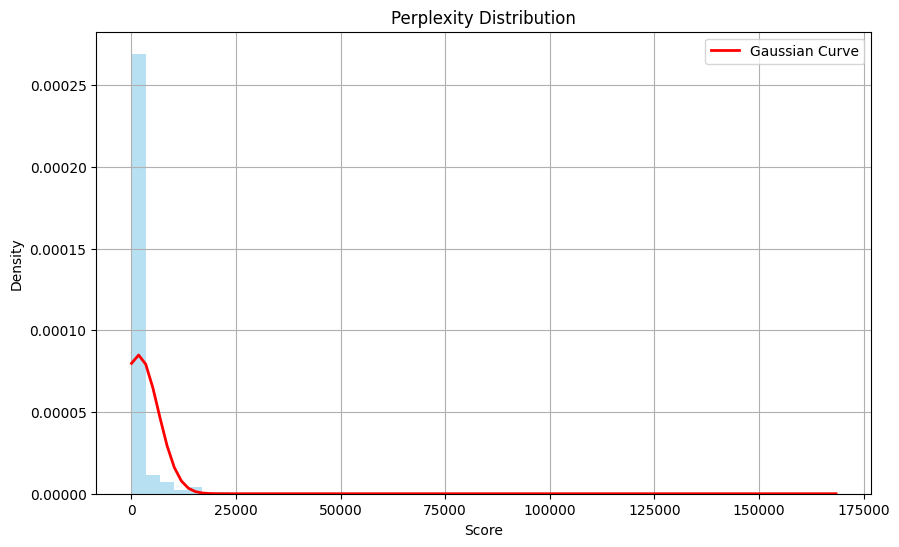

In [ ]:
scorer = Score(PerplexityFilter(threshold=100000.00, models_dir='./kenlm/wikipedia'), text_field='text', score_field='ppl')
scored_dataset = scorer(dataset)
plot_score_dist("Perplexity Distribution", scored_dataset.df['ppl'].compute())


In [ ]:
hi_ppl_df = dataset.df[dataset.df["ppl"] > 10000]
sample_pd = (hi_ppl_df.sample(frac=0.01, random_state=42).head(10))
for i, row in sample_pd.iterrows():
    print(f"Perplexity: {row['ppl']}, Text:\n{row['text']}", '\n', '#'*20)

<class 'dask_expr._collection.DataFrame'>
Perplexity: 1427.3, Text:
Your email address will be set as your 'Username'. Use this when signing in or resetting your password.

An upper-case character

A number

or Create an Account

This site uses cookies. By continuing to use our website, you are agreeing to our privacy policy. ----------
Perplexity: 1621.6, Text:
Display Result of

    Inclusive of all taxes

      Inclusive of all taxes

        Request permissionto reuse content from this site

        Copyright year :

        Products related to this item ----------
Perplexity: 1021.2, Text:
What is up to us? Studies on Causality and Responsibility in Ancient Philosophy

Reprint years

No versions found

    Upload a copy of this work     Papers currently archived: 105,810

Aristotle on what is up to us and what is contingent.Susan Sauvé Meyer - 2014 - In P. Destrée, What is Up to Us? Studies on Agency and Responsibility in ancient Philosophy. Sankt Augustin: Academia Verlag.

The w

In [ ]:
low_ppl_df = dataset.df[dataset.df["ppl"] < 1000]
sample_pd = (low_ppl_df.sample(frac=0.01, random_state=42).head(10))
for i, row in sample_pd.iterrows():
    print(f"Perplexity: {row['ppl']}, Text:\n{row['text']}", '\n', '#'*20)

Perplexity: 527.0, Text:
  • 50% off

Reduced head design for ease of 3D skills on the move and reverse lifting

Y1 Durashock Blend end cap to improve shock absorption and power transfer

Our 2023/24 range is here to celebrate the amazing nature, colours and culture that can be found in Africa. As a company, Y1 is now carbon neutral and we are continually looking to reduce our impact on the planet, from reducing single use plastics to offsetting our carbon footprint. We are only at the beginning of our sustainability journey and we have a long way to go, however our passion for growing the game feels especially relevant with this year's range.

The Y1 'Advanced Dribble Bow' thinned blade profile is perfect for the creative player looking to combine dribbling, 3D skills and passing from anywhere on the pitch. This profile was designed in collaboration with international Forwards, Midfielders and Defenders. This stick is a beautiful blend of balance and excitement - perfect for the all r

### 6. Deduplication 
Goal: removing duplicate or near-duplicate text
Duplicate passages can cause overfitting and give disproportionate weight to those examples if they appear many times in training
A simple approach is to hash each document (or each paragraph) and drop exact duplicates across the dataset.
Beyond exact matches, more fuzzy deduplication techniques like MinHash or SimHash are employed to catch near-duplicates.
> As an additional safeguard, most pipelines also perform decontamination – removing any content that overlaps with evaluation sets or popular benchmarks.

#### 6.1 Exact Dedup

In [ ]:
!pip install --extra-index-url https://pypi.nvidia.com "nemo-curator[all]"

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'initialize_client' is not defined

In [8]:
from nemo_curator.modules import ExactDuplicates
client = initialize_client(device='cuda')

/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45509 instead
  warnings.warn(


cuDF Spilling is enabled
GPU cluster initialized with 2 workers


2025-05-21 21:40:13,771 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:41211' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('_read_json_partition-getitem-_add_id_fast_partition-fad7963e39e4568aab9f0e3f9a5392be', 0)} (stimulus_id='handle-worker-cleanup-1747834813.7717397')


In [ ]:
from nemo_curator import ExactDuplicates
from nemo_curator import AddId

# put dataframe on GPU
dataset = DocumentDataset.read_json(get_all_files_paths_under('./cc_sample_lang_sep/EN'), add_filename=True, backend='cudf') 
# we need to assign unique id for each document, so duplicates can be tracked
add_id = AddId(id_field="doc_id", id_prefix="doc_id") 
dataset = add_id(dataset).persist()

# Initialize the deduplication object
exact_duplicates = ExactDuplicates(
  id_field="doc_id",
  text_field="text",
  perform_removal=True,
  cache_dir="cache_cc_exact_dd", # Recommended to specify a cache_dir if perform_removal=True
)
# When perform_removal=False, it will only call .identify_duplicates() and return the list of duplicate IDs.
# When perform_removal=True, then exact_dup outputs the dataset with the duplicates removed.
# It will behave by calling .identify_duplicates() and .remove() in sequence.
duplicate_docs = exact_duplicates.identify_duplicates(dataset)
duplicate_docs.df.head()

Reading 2 files with blocksize='1gb' / files_per_partition=None


/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/utils/distributed_utils.py:429: UserWarning: If underlying JSONL data does not have a consistent schema, reading with blocksize will fail. Please use files_per_partition approach instead.
  warnings.warn(
INFO:ExactDuplicates:Starting lazy hash generation
INFO:ExactDuplicates:Lazy hash generation complete for 1 partitions
INFO:ExactDuplicates:Starting execution for ExactDedup


INFO:ExactDuplicates:Time taken for Exact Dedup Computation = 0.1397554874420166s and output written at cache_cc_exact_dd/_exact_duplicates.parquet


Reading 1 files with blocksize=None / files_per_partition=1


/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/utils/distributed_utils.py:677: UserWarning: Consider passing in blocksize for better control over memory usage.
  warnings.warn(


,_hashes,doc_id
0,0d6187a6dbf87b209ebf23f8fee502f9,doc_id-124820
1,4ff5fff3e81b375bf0b16c7d728a2a46,doc_id-129340
2,2aefa9c576a0f043bfd92ca8e37e32d3,doc_id-129450
3,fd132001641f42650bbbe3f76b2ad6cd,doc_id-072960
4,12ea182998ac8ea2d174fd2544c3c4b8,doc_id-125020
5,24f4583b85ed3b282b5952aa1574cc44,doc_id-117840
6,fd132001641f42650bbbe3f76b2ad6cd,doc_id-072970
7,5919fc851ae6b828f427f68c995e1c73,doc_id-153610
8,f786a71a8339021a4f3aa28b1c8d92dc,doc_id-102480
9,b6d4223e60986fa4c9af77ee5f7149c5,doc_id-139530


In [44]:
print(f"Number of exact duplicated file: {len(duplicate_docs)}")
exact_dedup_result = pd.read_parquet(os.path.join('cache_cc_exact_dd/_exact_duplicates.parquet'))
print(f"Number of exact duplicated document:{len(exact_dedup_result)}")
duplicated_list = exact_dedup_result.groupby("_hashes")["doc_id"].agg(list).reset_index().head()
duplicated_list.head()

Number of exact duplicated file: 2184
Number of exact duplicated document:2184


,_hashes,doc_id
0,00e8e1ba077413be6af05b8a43301f0f,"[doc_id-153430, doc_id-023270, doc_id-162300]"
1,011e06a6fcbc785425f4ba11d838a21d,"[doc_id-035330, doc_id-015930, doc_id-132480, ..."
2,017e7f3d84bf083737672d58fdf7201d,"[doc_id-189890, doc_id-089580]"
3,0245f799980d90f8e2ec19d75fccecf3,"[doc_id-082900, doc_id-105080]"
4,02507f91c3a7ed21ab9094c7cd3d9fd7,"[doc_id-185110, doc_id-146650, doc_id-167640, ..."


In [45]:
# verify duplicates
text1 = (dataset.df.loc[dataset.df['doc_id'] == "doc_id-153430", 'text']
         .compute()
         .iloc[0])
print(text1)

print('-' * 10)

text2 = (dataset.df.loc[dataset.df['doc_id'] == "doc_id-162300", 'text']
         .compute()
         .iloc[0])
print(text2)

Try refreshing the page. If that doesn't work, there may be a network issue, and you can use our self test page to see what's preventing the page from loading.

Learn more about possible network issues or contact support for more help.
----------
Try refreshing the page. If that doesn't work, there may be a network issue, and you can use our self test page to see what's preventing the page from loading.

Learn more about possible network issues or contact support for more help.


In [46]:
deduplicated_dataset = exact_duplicates.remove(dataset, duplicate_docs)

#### 6.2. Fuzzy Deduplication
When removing near-duplicates within the corpus, we perform fuzzy deduplication at the document level in order to remove documents with high Jaccard similarity scores (set similarity).

Steps:

1. Compute Minhashes: compute MinHash Signatures on each document. NeMo Curator currently only supports character-based n-grams for MinHashing. An approximate metric of ~4.5 characters per word can be used to determine the n-gram size for users familiar with word-based ngrams.

2. Locality Sensitive Hashing: Perform LSH to find candidate duplicates.

3. Buckets to Edgelist: If not using the false positive check, we directly convert the LSH buckets to edges for the connected components computation.

    *False Positive Check: Due to the approximate nature of the bucketing via MinHash + LSH (Leskovec et al., 2020), NeMo Curator provides the option to further process each of the buckets by computing some pairwise Jaccard similarity scores between documents in each bucket and filter out false positives that might have been hashed into the same bucket.*

1. Connected Components: Due to the approximate nature of LSH, documents that are near duplicates may be assigned into different buckets with a few overlapping documents between these buckets. We use a GPU accelerated connected components algorithm to find all connected components in the graph formed by the edges between documents in the same bucket.

The result from the connected components step is a list of document IDs and the group they belong to. All documents in the same group are considered near duplicates. These results can be used to remove the near duplicates from the corpus.

In [47]:
from nemo_curator import FuzzyDuplicates, FuzzyDuplicatesConfig

config = FuzzyDuplicatesConfig(
    cache_dir="./cache_cc_fuzzy_dd", # must be cleared between runs
    id_field="doc_id",
    text_field="text",
    perform_removal=False,
    seed=42,
    char_ngrams=24, # Rule-of-thumb: 5-word gram. Chinese: 2-3 chars per word. English: 4-5 chars per word
    num_buckets=20, # Number of bands
    hashes_per_bucket=13, # Number of rows per band
    # number of permuatations = b*r
    use_64_bit_hash=False, # 32bit/62bit during shingle hashing
    buckets_per_shuffle=2,
    false_positive_check=False,
    jaccard_threshold=0.8, # only used during FP checking
)

/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modules/config.py:125: UserWarning: False positive check is disabled. Unused arguments ['jaccard_threshold'] will be ignored
  warnings.warn(
/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modules/config.py:138: UserWarning: In future NeMo Curator releases, the default value for perform_removal will be True.
  warnings.warn(


In [ ]:
from nemo_curator import FuzzyDuplicates

# Initialize the deduplication object
fuzzy_duplicates = FuzzyDuplicates(config=config)
duplicate_docs = fuzzy_duplicates.identify_duplicates(deduplicated_dataset)
print(f"Number of fuzzy duplicated file: {len(duplicate_docs)}")
duplicate_docs.head()

/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modules/base.py:122: UserWarning: In future NeMo Curator releases, the default value for perform_removal will be True.
  warnings.warn(
INFO:FuzzyDuplicates:Starting execution for Minhashes


/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modules/fuzzy_dedup/minhash.py:219: UserWarning: Output path ./cache_cc_fuzzy_dd/_minhashes.parquet already exists and will be overwritten
  warnings.warn(


Stage 1: Starting Minhash + LSH computation


INFO:FuzzyDuplicates:Time taken for Minhash signature computation = 0.3775002956390381s and output written at ./cache_cc_fuzzy_dd/_minhashes.parquet
/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modules/fuzzy_dedup/lsh.py:249: UserWarning: Output path ./cache_cc_fuzzy_dd/_buckets.parquet already exists and will be overwritten
  warnings.warn(
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_0', '_bucket_1']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_2', '_bucket_3']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_4', '_bucket_5']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_6', '_bucket_7']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_8', '_bucket_9']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_10', '_bucket_11']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_12', '_bucket_13']
INFO:FuzzyDuplicates:Wrote data for buckets: ['_bucket_14', '_bucket_15']
INFO:FuzzyDuplicates:Wrote data fo

Stage 1: Minhash + LSH complete!
Stage 2: Starting LSH Buckets to Graph Edgelist
Stage 2: Starting LSH Buckets to Graph Edgelist Complete!
Stage 3: Connected Components across buckets


INFO:FuzzyDuplicates:Time taken for merge and write = 0.07245516777038574s and output written at ./cache_cc_fuzzy_dd/encoded_jaccard_pair/
INFO:FuzzyDuplicates:Time taken for Encoding Jaccard Pairs = 0.08490228652954102s and output written at ./cache_cc_fuzzy_dd/encoded_jaccard_pair/
INFO:FuzzyDuplicates:Time taken for Dedup Encoding Jaccard Pairs = 0.0844724178314209s and output written at ./cache_cc_fuzzy_dd/final_dedup_encoded_jaccard_pair.parquet
/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/cudf/core/reshape.py:384: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  warnings.warn(
INFO:FuzzyDuplicates:Result of connected compoinents are # of groups : 167, # of docs removed : 273, # nodes = 440, # rows in labels_df = 440
INFO:FuzzyDuplicates:Tim

Stage 3: Connected Components across buckets complete!
Reading 1 files with blocksize=None / files_per_partition=1
Number of fuzzy duplicated file: 440


/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/utils/distributed_utils.py:677: UserWarning: Consider passing in blocksize for better control over memory usage.
  warnings.warn(


In [56]:
duplicated_list = duplicate_docs.df.groupby("group")["doc_id"].agg(list).reset_index().head()
duplicated_list.head()

,group,doc_id
0,7,"[doc_id-085040, doc_id-083630, doc_id-195700, ..."
1,15,"[doc_id-093370, doc_id-194720, doc_id-080160, ..."
2,22,"[doc_id-041730, doc_id-159470, doc_id-196720, ..."
3,26,"[doc_id-063660, doc_id-198690, doc_id-109540, ..."
4,27,"[doc_id-091440, doc_id-091410, doc_id-091420, ..."


In [57]:
# verify duplicates
text1 = (dataset.df.loc[dataset.df['doc_id'] == "doc_id-085040", 'text']
         .compute()
         .iloc[0])
print(text1)

print('-' * 10)

text2 = (dataset.df.loc[dataset.df['doc_id'] == "doc_id-083630", 'text']
         .compute()
         .iloc[0])
print(text2)

Welcome to our website! As we have the ability to list over one million items on our website (our selection changes all of the time), it is not feasible for a company our size to record and playback the descriptions on every item on our website. However, if you have a disability we are here to help you. Please call our disability services phone line at 618-242-1579 during regular business hours and one of our kind and friendly personal shoppers will help you navigate through our website, help conduct advanced searches, help you choose the item you are looking for with the specifications you are seeking, read you the specifications of any item and consult with you about the products themselves. There is no charge for the help of this personal shopper for anyone with a disability. Finally, your personal shopper will explain our Privacy Policy and Terms of Service, and help you place an order if you so desire.

How many years did your last washer last?

How many loads of laundry

do you d

In [ ]:
deduplicated_dataset = fuzzy_duplicates.remove(deduplicated_dataset, duplicate_docs)
print(f'Number of documents: {len(deduplicated_dataset)}')

Number of documents: 18215


### 7. PII Identification and Removal
Searching personal identifying information and remove/replace it.  

#### 7.1 Presidio framework
Predefined or custom PII recognizers. It utilized Named Entity Recognition, regular expressions, rule based logic and checksum with relevant context in multiple languages.

- Pros: Fast, Low memory requirement  
- Cons: Chinese not supported :(

In [ ]:
client.cluster.close()
client.shutdown()
client = initialize_client(device='cpu')

CPU cluster initialized with 1 workers


In [ ]:
from nemo_curator.modules.modify import Modify
from nemo_curator.modifiers.pii_modifier import PiiModifier

modifier = PiiModifier(
    language="en",
    supported_entities=[
        "ADDRESS",
        "CREDIT_CARD",
        "EMAIL_ADDRESS",
        "DATE_TIME",
        "IP_ADDRESS",
        "LOCATION",
        "PERSON",
        "URL",
        "US_SSN",
        "US_PASSPORT",
        "US_DRIVER_LICENSE",
        "PHONE_NUMBER",
    ],
    anonymize_action="mask", # ['redact', 'mask', 'replace']
    new_value="**",
    batch_size=1000,
    device="cpu",
)

In [ ]:
dataset = DocumentDataset.from_pandas(
    pd.DataFrame([
        'If you have emergencies, call me: 0912345678', 
        'No. 276, Section 1, Datong Rd, Xizhi District, New Taipei City, 221, this is the bank address',
        'A simple sentence'
    ],columns=['text'])
)
modify = Modify(modifier, text_field='text')
modified_dataset = modify(dataset)
modified_dataset.df.head()

,text
0,********************************************
1,****************************** ***************...
2,A simple sentence


# 

#### LLM-based framework  
we will use NIM endpoint to serve a LLM, and prompt it to remove personal info

In [ ]:
from nemo_curator.modifiers.llm_pii_modifier import LLMPiiModifier
modifier = LLMPiiModifier(
    # Endpoint for the user's NIM
    base_url="https://integrate.api.nvidia.com/v1",
    api_key="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", # paste your API key here
    model="meta/llama-3.1-70b-instruct", # You can change this to other LLMs
    pii_labels=["phone", "address"],
    language="en",
)

In [25]:
dataset = DocumentDataset.from_pandas(
    pd.DataFrame([
        'If you have emergencies, call me: 0912345678', 
        'No. 276, Section 1, Datong Rd, Xizhi District, New Taipei City, 221, this is the bank address',
        'A simple sentence'
    ],columns=['text'])
)
modify = Modify(modifier, text_field='text')
modified_dataset = modify(dataset)
for i, row in modified_dataset.df.iterrows():
    print(row['text'])

If you have emergencies, call me: {{phone}}
No. 276, Section 1, Datong Rd, Xizhi District, New Taipei City, 221, this is the bank address
A simple sentence


In [ ]:
# need to customize system prompt if not using English
JSON_SCHEMA = {
    "type": "array",
    "items": {
        "type": "object",
        "required": ["entity_type", "entity_text"],
        "properties": {
            "entity_type": {"type": "string"},
            "entity_text": {"type": "string"},
        },
    },
}
pii_labels = ["phone_number", "address"]
modifier = LLMPiiModifier(
    # Endpoint for the user's NIM
    base_url="https://integrate.api.nvidia.com/v1",
    api_key= None# paste your API key here
    model="meta/llama-3.1-8b-instruct", # You can change this to other LLMs
    pii_labels=pii_labels,
    language="zh_TW",
    system_prompt=f"""你是一位專業的編輯（或可理解為隱私資訊處理專家）。使用者將會提供一些文字給你。
請從這些文字中找出所有個人識別資訊。
請依照此 JSON 綱要 (schema) 回傳結果：{str(JSON_SCHEMA)}
僅回傳文字中實際出現的實體。
非常重要的一點是，你回傳的 entity_text 必須是從輸入中完全複製的。
請勿對文字進行任何修改或標準化處理。
entity_type 必須是以下其中之一：{','.join(pii_labels)}"""
)

/home/jason101805/cht_llm/2025.05.22/.venv/lib/python3.11/site-packages/nemo_curator/modifiers/llm_pii_modifier.py:144: UserWarning: Custom system_prompt and custom pii_labels were both provided, but the PII labels should already be included in the system prompt. The pii_labels will be ignored.
  warnings.warn(


In [31]:
dataset = DocumentDataset.from_pandas(
    pd.DataFrame([
        '如果你有緊急情況，打給我：0912345678',
        '新北市汐止區大同路一段276號，我會在這邊等你',
        '一個簡單的句子'
    ],columns=['text'])
)
modify = Modify(modifier, text_field='text')
modified_dataset = modify(dataset)
for i, row in modified_dataset.df.iterrows():
    print(row['text'])

如果你有緊急情況，打給我：{{phone_number}}
{{address}}，我會在這邊等你
一個簡單的句子
